# 第二周 特征工程

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from utils import *
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss  
from sklearn.metrics import accuracy_score 
from sklearn.linear_model import LogisticRegression
%matplotlib inline

## 1、数据读取

In [2]:
#数据总数
lines = 0
fin = open("train.csv", 'rb')
for line in fin:
    lines += 1
fin.close()
print("number of records :%d" % lines)

number of records :40428968


In [3]:
#先读取1/4的数据热热身，id没用扔掉
data_train=pd.read_csv('train.csv',nrows=1e7)
data_train = data_train.drop('id', axis = 1)

In [4]:
#降采样，省点时间
sample_rate=0.01
if sample_rate < 1.0:
    np.random.seed(999)
    r1 = np.random.uniform(0, 1, data_train.shape[0])  #产生0～40M的随机数    
    data_train = data_train.iloc[r1 < sample_rate,:]
    print ("testing with small sample of training data, ", data_train.shape)

testing with small sample of training data,  (99841, 23)


## 2、特征工程

In [5]:
#特征组合hour,site_app....
#多少号
data_train['day']=np.round(data_train['hour'] % 10000 / 100)
#一天第几小时
data_train['hour1'] = np.round(data_train['hour'] % 100)
#从开始的第几个小时
data_train['day_hour'] = (data_train.day.values - 21) * 24 + data_train.hour1.values
#周几，随便开始的，反正是类别变量
data_train['weekday']=np.round(data_train['hour'] % 10000 / 100)%7

In [6]:
#除了click，其余特征编码为数值，节约内存
for var in data_train.columns:
    if var in ['click']:
        pass
    else:
        data_train[var]=data_train[var].astype('category').values.codes        

In [7]:
#将出现频率低于10的特征替换为else
data_train=fill_outlier(data_train,fre=10,name='else')

banner_pos have been replaced
site_id have been replaced
site_domain have been replaced
site_category have been replaced
app_id have been replaced
app_domain have been replaced
app_category have been replaced
device_id have been replaced
device_ip have been replaced
device_model have been replaced
C14 have been replaced
C15 have been replaced
C16 have been replaced
C17 have been replaced
C19 have been replaced
C20 have been replaced
C21 have been replaced


In [8]:
#均值编码
meancode=data_train[:]
P_A=data_train['click'].value_counts()[1]/data_train['click'].value_counts().sum()
#筛选出点击率为1的事件
data_train_click=data_train[data_train['click']==1]
for v in data_train.columns:
    if v=='click':
        pass
    else:
        print('\n%s属性的取值和次数'%v)
        P=pd.concat([data_train[v].value_counts(),data_train[v].value_counts(normalize=True),\
                       data_train_click[v].value_counts(normalize=True)],\
                       axis=1,join_axes=[data_train[v].value_counts().index],keys=['特征分布','P_C','P_C|A']).fillna(0)
        #P(A│ci)=(P(ci│A)P(A))/(P(ci))
        P['P_A|C/后验概率']=(P['P_C|A']*P_A)/P['P_C']
        P['概率提升比%']=(P['P_A|C/后验概率']-P_A)*100/P_A
        lemda=1/((np.exp(P['特征分布']-20)/100)+1)
        P['meancode']=lemda*P_A+(1-lemda)*P['P_A|C/后验概率']        
        meancode[v]=meancode[v].replace(list(P['meancode'].index),list(P['meancode'].values)) 
meancode=meancode.drop('click',axis=1)
col=[]
for var in meancode.columns:
    col.append('code_'+var)
meancode.columns=col
meancode.head()


hour属性的取值和次数

C1属性的取值和次数

banner_pos属性的取值和次数

site_id属性的取值和次数

site_domain属性的取值和次数

site_category属性的取值和次数

app_id属性的取值和次数

app_domain属性的取值和次数

app_category属性的取值和次数

device_id属性的取值和次数

device_ip属性的取值和次数

device_model属性的取值和次数

device_type属性的取值和次数

device_conn_type属性的取值和次数

C14属性的取值和次数

C15属性的取值和次数

C16属性的取值和次数

C17属性的取值和次数

C18属性的取值和次数

C19属性的取值和次数

C20属性的取值和次数

C21属性的取值和次数

day属性的取值和次数

hour1属性的取值和次数

day_hour属性的取值和次数

weekday属性的取值和次数


,code_hour,code_C1,code_banner_pos,code_site_id,code_site_domain,code_site_category,code_app_id,code_app_domain,code_app_category,code_device_id,...,code_C16,code_C17,code_C18,code_C19,code_C20,code_C21,code_day,code_hour1,code_day_hour,code_weekday
37,0.161369,0.163542,0.162868,0.131827,0.134832,0.140056,0.138528,0.138528,0.181850,0.165987,...,0.156461,0.084553,0.147997,0.142737,0.157746,0.107680,0.173759,0.170765,0.161369,0.173759
177,0.161369,0.163542,0.162868,0.204586,0.204586,0.195482,0.185673,0.182834,0.186835,0.165987,...,0.156461,0.192816,0.147997,0.142737,0.181245,0.187803,0.173759,0.170765,0.161369,0.173759
217,0.161369,0.163542,0.162868,0.204586,0.204586,0.195482,0.185673,0.182834,0.186835,0.165987,...,0.156461,0.192816,0.147997,0.142737,0.213944,0.187803,0.173759,0.170765,0.161369,0.173759
333,0.161369,0.163542,0.162868,0.165154,0.164953,0.166852,0.185673,0.182834,0.186835,0.165987,...,0.156461,0.084553,0.147997,0.142737,0.181245,0.107680,0.173759,0.170765,0.161369,0.173759
359,0.161369,0.238532,0.162868,0.131827,0.134832,0.140056,0.137972,0.182834,0.186835,0.157837,...,0.156461,0.288793,0.140741,0.283384,0.181245,0.280989,0.173759,0.170765,0.161369,0.173759


In [9]:
#onehot之前再编码一次，Onehot不能处理字符串
for var in data_train.columns:
    if var in ['click']:
        pass
    else:
        data_train[var]=data_train[var].astype('category').values.codes     
#onehot
x=data_train.drop('click',axis=1)
data_train_x=sparse.hstack((OneHotEncoder().fit_transform(x),meancode.values)).toarray()
data_train_y=data_train['click']

## 3、基本模型训练效果及论证

### 3.1 logistic回归

In [14]:
#设置参数，fit
penaltys_lr = ['l1','l2']
Cs_lr = [0.00001,0.0001,0.001, 0.01, 0.1, 1]
parameters_lr = dict(penalty =penaltys_lr,C =Cs_lr)
estimator_lr= LogisticRegression()
grid_lr= GridSearchCV(estimator_lr,parameters_lr,cv=5, scoring='neg_log_loss')
grid_lr.fit(meancode.values,data_train_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

### cv结果

In [15]:
grid_lr.cv_results_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

{'mean_fit_time': array([ 0.12815995,  0.21859989,  0.16543999,  0.22232003,  0.17319994,
         0.23207998,  0.59896002,  0.32676001,  4.44284005,  0.45379996,
        22.48960018,  0.57416   ]),
 'std_fit_time': array([0.01290059, 0.04910818, 0.03041036, 0.02084404, 0.01245031,
        0.0122283 , 0.03094804, 0.01504095, 0.9561929 , 0.03998805,
        2.51681351, 0.03619289]),
 'mean_score_time': array([0.00872011, 0.01312003, 0.00903997, 0.00299997, 0.00623994,
        0.01116014, 0.00884008, 0.00644002, 0.00311999, 0.01248012,
        0.00783992, 0.01248012]),
 'std_score_time': array([0.00355441, 0.00567621, 0.00544264, 0.00599995, 0.00764233,
        0.00730968, 0.00601646, 0.00789372, 0.00623999, 0.00624006,
        0.00697692, 0.00624006]),
 'param_C': masked_array(data=[1e-05, 1e-05, 0.0001, 0.0001, 0.001, 0.001, 0.01, 0.01,
                    0.1, 0.1, 1, 1],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, Fals

### 调参结果、logloss

In [16]:
print(-grid_lr.best_score_)
print(grid_lr.best_params_)

0.4000322357483718
{'C': 0.1, 'penalty': 'l1'}


### 可视化

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


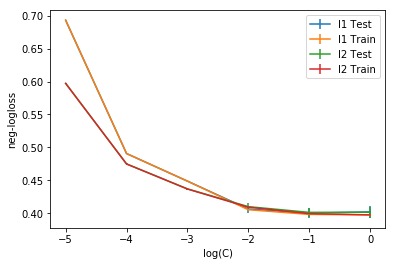

In [17]:
# plot CV误差曲线
from matplotlib import pyplot
test_means = grid_lr.cv_results_[ 'mean_test_score' ]
test_stds = grid_lr.cv_results_[ 'std_test_score' ]
train_means = grid_lr.cv_results_[ 'mean_train_score' ]
train_stds = grid_lr.cv_results_[ 'std_train_score' ]

# plot results
n_Cs = len(Cs_lr)
number_penaltys = len(penaltys_lr)
test_scores = np.array(test_means).reshape(n_Cs,number_penaltys)
train_scores = np.array(train_means).reshape(n_Cs,number_penaltys)
test_stds = np.array(test_stds).reshape(n_Cs,number_penaltys)
train_stds = np.array(train_stds).reshape(n_Cs,number_penaltys)

x_axis = np.log10(Cs_lr)
for i, value in enumerate(penaltys_lr):
    #pyplot.plot(log(Cs), test_scores[i], label= 'penalty:'   + str(value))
    pyplot.errorbar(x_axis, -test_scores[:,i], yerr=test_stds[:,i] ,label = penaltys_lr[i] +' Test')
    pyplot.errorbar(x_axis, -train_scores[:,i], yerr=train_stds[:,i] ,label = penaltys_lr[i] +' Train')
    
pyplot.legend()
pyplot.xlabel( 'log(C)' )                                                                                                      
pyplot.ylabel( 'neg-logloss' )
pyplot.savefig('Logisticgrid_lrSearchCV_C.png' )
pyplot.show()